<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/compromise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Picking the best option
## Multiobjective compromising

Often, decision making involves two or more possibly contradictory criteria to simultaneously optimize. Picking the best in the sense of one criterion tends to imply a sacrifice in another. In this session, we will explore how to deal with these types of situations.

As an example scenario, let's assume we have been looking to buy a used car. We have a bunch of options for which we have quantified the criteria we wish to take into account.

In [1]:
n = 200 # how many alternatives to generate

import pandas as pd
from random import randint

# assign a price to each car in CAD
price = pd.Series([ randint(3500, 35000) for car in range(n) ], name = 'Price')

# assign a milage
milage = pd.Series([ randint(200, 150000) for car in range(n) ], name = 'Milage')

# assign how many miles per gallon the car runs on average
mpg = pd.Series([ randint(30, 70) for car in range(n) ], name = 'FuelEfficiency')

# assign carbon dioxide emissions per gallon in grams
co2 = pd.Series([ randint(8000, 9000) for car in range(n) ], name = 'Emissions')

# subjective coolness on scale from 1 (lame) to 5 (neat)
cool = pd.Series([ randint(1, 5) for car in range(n) ], name = 'Rating')

We can combine all this information into a **data frame**, a spreadsheet of sorts. To do so, we concatenate the lists as columns. We can look at the "head" (the first few rows) of the result to see what we have created.

In [2]:
import pandas as pd

attributes = [ price, milage, mpg, co2, cool ]
cars = pd.concat(attributes, axis = 1)
cars.head()

,Price,Milage,FuelEfficiency,Emissions,Rating
0,21945,134441,56,8302,4
1,18796,147127,36,8744,1
2,14828,90306,40,8486,4
3,12686,60776,65,8050,4
4,7371,73060,68,8998,3


We can now easily ask questions like "which car is the cheapest?".

In [3]:
cheapest = cars['Price'].idxmin()
cars.loc[cheapest]

Price              3513
Milage            73492
FuelEfficiency       62
Emissions          8507
Rating                3
Name: 173, dtype: int64

Or "which ones are the five-star rated alternatives in terms of how cool I think they are?".

In [4]:
cars.loc[ cars['Rating'] == 5 ]

,Price,Milage,FuelEfficiency,Emissions,Rating
14,34899,88168,35,8762,5
19,29685,10304,30,8384,5
22,18970,50607,44,8737,5
25,27019,27891,60,8837,5
27,23741,10258,64,8211,5
33,26862,27132,42,8038,5
36,18143,97076,63,8375,5
38,24388,38798,34,8010,5
59,32236,97043,58,8890,5
63,26600,39767,54,8290,5


Which ones are both cool and cost less than 10k?

In [5]:
cars[ (cars['Rating'] == 5) & (cars['Price'] < 10000) ]

,Price,Milage,FuelEfficiency,Emissions,Rating
68,3939,120476,51,8938,5
79,3691,94558,53,8784,5
99,7831,15114,50,8924,5
110,6562,63618,61,8938,5
131,7332,114581,47,8993,5
142,5951,5135,68,8643,5
147,7212,107988,31,8625,5
188,8695,5639,57,8263,5


Our next difficulty lies in that we want to **maximize** some of these criteria, while we wish to **minimize** others. It is easier to automate the processing if all criteria "work the same way".

Luckily, math solves this. If we multiply a function by -1, it's hills become its valleys and vice versa. To understand this better, let's improvise a function that has nothing to do with anything, just to see what happens when we multiply it by -1.

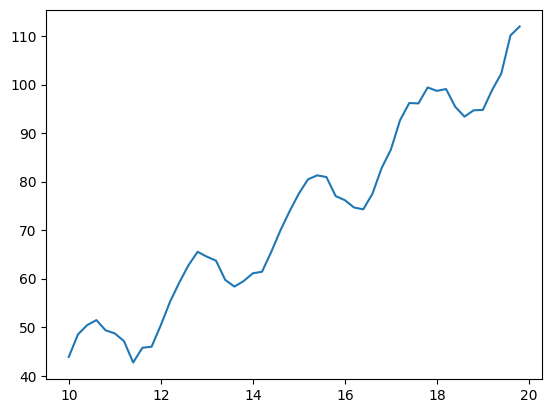

In [6]:
import numpy as np
x = np.arange(10, 20, 0.2)
r = np.random.rand(x.size)
y = 6.5 * np.sin(34 * x) + 1.8 * x**1.4 - 0.6 * x + 5 * r
import matplotlib.pyplot as plt
plt.plot(x, y)
plt.show()

Now, we keep the same x but use -y instead.

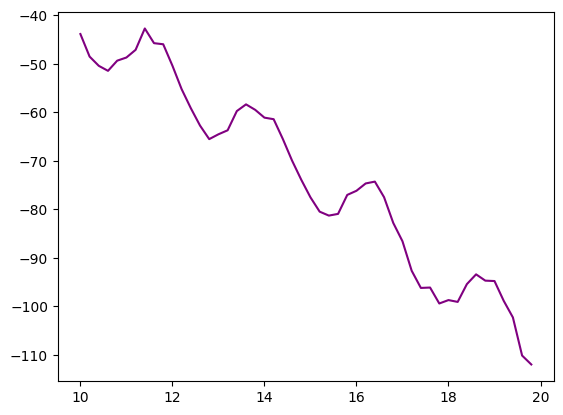

In [7]:
plt.plot(x, -y, c = 'purple')
plt.show()

In [8]:
ideal = {
  'Price' : 1, # minimize
  'Milage' : 1, # also minimize
  'FuelEfficiency' : - 1, # maximize (minimize the negative)
  'Emissions' : 1, # minimize again
  'Rating' : -1 # maximize
}

multipliers = [ ideal[c] for c in cars.columns ]
multipliers

[1, 1, -1, 1, -1]

In [9]:
def dominates(challenger, challenged): # smaller is better
  if all(v <= w for v, w in zip(challenger, challenged)): # if all aspects are at least as good
    return any( v < w for v, w in zip(challenger, challenged)) # and at least one is actually better
  return False


x = [ 1, 2, 3 ]
y = [ 0, 1, 2 ]
z = [ 1, 4, 3 ]

print('x vs. y', dominates(x, y))
print('y vs. x', dominates(y, x))
print('x vs. z', dominates(x, z))
print('z vs. x', dominates(z, x))
print('z vs. y', dominates(z, y))
print('y vs. z', dominates(y, z))

x vs. y False
y vs. x True
x vs. z True
z vs. x False
z vs. y False
y vs. z True


In [10]:
nondominated = set()

for i, data in cars.iterrows():
  car = [ m * v for m, v in zip(multipliers, data) ]
  discard = False # assume it to be invincible
  for j in range(i + 1, n): # check all the other cars
    otherData = cars.iloc[j] # get their data
    alt = [ m * v for m, v in zip(multipliers, otherData) ]
    if dominates(alt, car): # challenge the car with the alternative
      discard = True # we will not want to consider the loser
      break # no need to check further, it was already beaten
  if not discard: # nothing beat it
    nondominated.add(i) # remember the row

len(nondominated)

74

In [11]:
keep = sorted(list(nondominated))
candidates = cars.iloc[keep]
candidates

,Price,Milage,FuelEfficiency,Emissions,Rating
3,12686,60776,65,8050,4
7,7220,14865,38,8029,1
12,11407,46479,66,8201,1
20,4420,90064,70,8191,4
26,16335,100288,65,8494,4
...,...,...,...,...,...
194,18756,37796,34,8139,3
196,15361,144038,54,8490,5
197,14629,100448,38,8372,4
198,15768,42281,52,8983,5


In [12]:
candidates.loc[candidates['Price'].idxmin()]

Price              3513
Milage            73492
FuelEfficiency       62
Emissions          8507
Rating                3
Name: 173, dtype: int64

In [13]:
candidates.loc[candidates['Price'].idxmax()]

Price             34454
Milage            55598
FuelEfficiency       68
Emissions          8268
Rating                1
Name: 150, dtype: int64

In [14]:
budget = 12000
stars = 3
consider = candidates[ (candidates['Rating'] >= stars) & (candidates['Price'] <= budget) ]
consider

,Price,Milage,FuelEfficiency,Emissions,Rating
20,4420,90064,70,8191,4
60,4980,70827,53,8251,4
79,3691,94558,53,8784,5
83,11231,16903,63,8414,3
96,10425,80710,32,8038,3
119,7449,102736,45,8294,4
123,6447,959,36,8929,3
134,6129,98993,69,8062,3
140,4795,107120,31,8024,3
142,5951,5135,68,8643,5


In [15]:
importance = { 'Milage': 0.3, 'FuelEfficiency': 0.5, 'Emissions': 0.2 }
sum(importance.values())

1.0

In [16]:
attr = importance.keys()
factor = [ importance[a] * ideal[a] for a in attr ]
factor

[0.3, -0.5, 0.2]

In [17]:
compromise = []
for i, data in consider.iterrows():
  combo = sum( [ f * d for f, d in zip(factor, data) ])
  compromise.append(combo)

cand = consider.copy()
l = 'Combination'
cand[l] = compromise
sorted = cand.sort_values(by = [l])
sorted.head(10) # top ten in terms of the lowest (best) combination score

,Price,Milage,FuelEfficiency,Emissions,Rating,Combination
162,10202,148620,60,8114,4,-71237.4
180,10073,143588,56,8142,3,-68760.9
176,6139,117130,40,8874,3,-56715.3
140,4795,107120,31,8024,3,-52115.3
147,7212,107988,31,8625,5,-51824.2
119,7449,102736,45,8294,4,-49124.3
134,6129,98993,69,8062,3,-47644.0
79,3691,94558,53,8784,5,-46161.1
20,4420,90064,70,8191,4,-43692.0
96,10425,80710,32,8038,3,-37221.1


In [18]:
vars = ['Milage', 'FuelEfficiency', 'Emissions']
threedim = cand[vars]
threedim.head()

,Milage,FuelEfficiency,Emissions
20,90064,70,8191
60,70827,53,8251
79,94558,53,8784
83,16903,63,8414
96,80710,32,8038


In [19]:
import numpy as np

idx = threedim.index
cols = threedim.columns
matrix = np.array([ [ threedim[c][i] for c in cols ] for i in idx ])
print(matrix[:5])

[[90064    70  8191]
 [70827    53  8251]
 [94558    53  8784]
 [16903    63  8414]
 [80710    32  8038]]


In [20]:
x = matrix[:, 0]
y = matrix[:, 1]
z = matrix[:, 2]

x[:5]

array([90064, 70827, 94558, 16903, 80710])

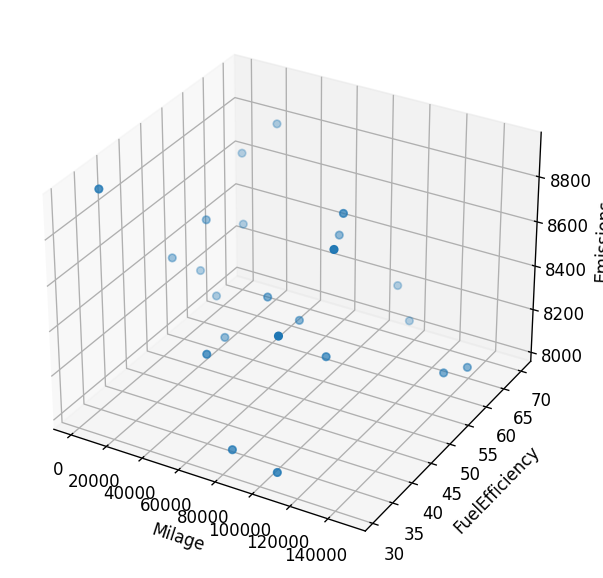

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize = (8, 6), dpi =  120)
a = fig.add_subplot(projection = '3d')
a.scatter(x, y, z, marker = 'o')
a.set_xlabel(vars[0])
a.set_ylabel(vars[1])
a.set_zlabel(vars[2])
plt.show()

In [22]:
stars = dict()
for quantity in [3, 4, 5]: # we already filtered out 1 and 2
  stars[quantity] = cand.loc[ cand['Rating'] == quantity ]

marker = {
  5 : '*', # use a star for 5
  4 : 'P', # use a thick plus for 4
  3 : 'd' # use a thin diamond for 3
}

for q in stars:
  print(q, len(stars[q]), marker[q])

3 12 d
4 6 P
5 5 *


In [26]:
data = dict()

for q in stars:
  subset = cand.loc[ cand['Rating'] == q ] # match the stars
  td = subset[vars] # get the three axis values
  M = np.array([ [ td[c][i] for c in td.columns ] for i in td.index ])
  color = subset['Price'].tolist()
  data[q] = (M, color)

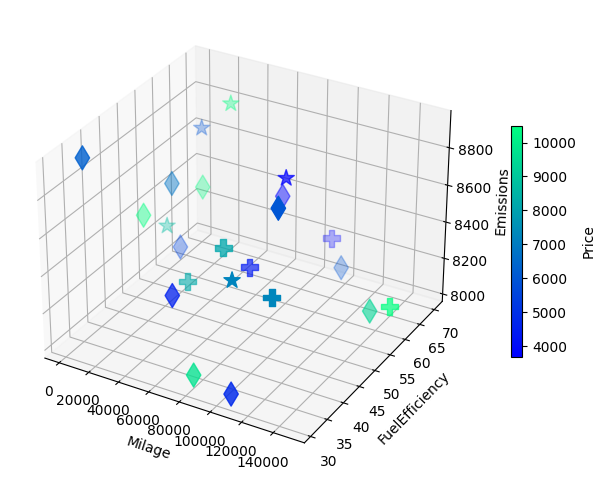

In [27]:
fig = plt.figure(1, figsize = (10, 6), dpi =  100)
a = fig.add_subplot(projection = '3d')
for q in stars:
  m, color = data[q]
  x = m[:, 0]
  y = m[:, 1]
  z = m[:, 2]
  plot = a.scatter(x, y, z, marker = marker[q], c = color, cmap = plt.cm.winter, s = 150)
a.set_xlabel(vars[0])
a.set_ylabel(vars[1])
a.set_zlabel(vars[2])
legend = fig.colorbar(plot, orientation = 'vertical', shrink = 0.5)
legend.set_label('Price')
plt.show()

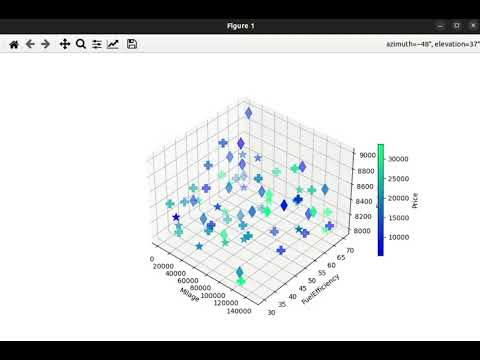

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo('c-vNm6lgeRQ')